# Detecting a checkerboard in images

## Summary
_This notebook contain a toy implementation of the checkerboard detection and matching method described in the tech report
[Robust and Automatic Calibration Target Extraction from Images](https://drive.google.com/file/d/0B7xGYrqYvG-9bmFGTXBNOW5jUkE/view), by Francesco Callari and Roman Waupotitsch._

_Only the Image Analysis (Sec. 2 in the paper) and Topological Analysis (Sec. 3) will be covered. A separate notebook will cover the subject of the Geometrical Analysis (Sec. 4), but using a more robust algorithm that uses [Matsunaga and Kanatani's "cross-ratio barcode" pattern](https://www.semanticscholar.org/paper/Optimal-Grid-Pattern-for-Automated-Matching-Using-Matsunaga-Kanatani/8c57a5a20eaf9d8d0f16faa2153a80003ef50cdb)._

_The emphasis will be on readability, with little or no effort made at optimizing performance beyond the obvious._

## Preliminaries
Import libraries, define a common method to show images.

In [1]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image

In [2]:
def show_image(img, scale=1):
    """
    Display an image in the notebook.
    """
    img = np.uint8(np.clip(img, 0, 255))
    if scale > 1:
        size = (scale * img.shape[1], scale * img.shape[0])
        img = cv2.resize(img, size)
    f = io.BytesIO()
    PIL.Image.fromarray(img).save(f, 'png')
    display(Image(data=f.getvalue()))

##  Image Analysis

This covers Section 2 of the paper.

I will refer throughout to the fairly challenging image below. The checkerboard is entirely in the image, but there are confusing targets in the background. 

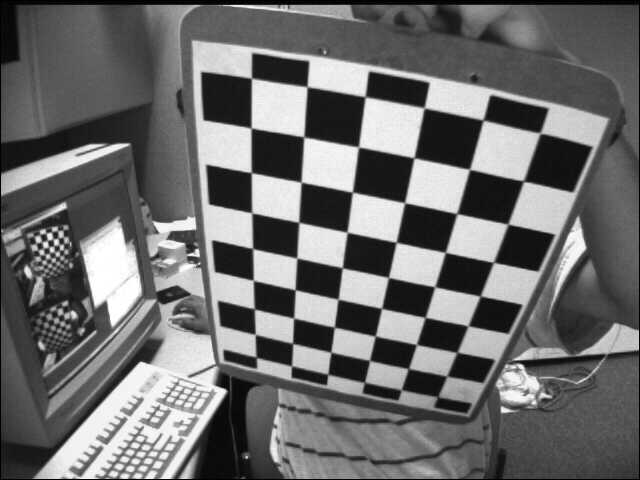

In [3]:
img = cv2.imread('images/one_way_train_0000.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(img)

#### Corner Detection

Let's begin with a bare-bones implementation of the [Harris-Stephens corner detector](https://en.wikipedia.org/wiki/Harris_Corner_Detector).

In [4]:
def harris(img, radius=2):
    """
    Harris-Stephens corner detector.
    :param img : numpy array containing a single-channel (grayscale) image.
    :param radius : half-width and half-height of the square convolution filters.
    :returns : filtered image as a float32 array of the same shape as the image.
    """
    fimg = img.astype(np.float32) / 255.0
    ix = cv2.Scharr(fimg, cv2.CV_32F, 1, 0)
    iy = cv2.Scharr(fimg, cv2.CV_32F, 0, 1)
    ix2 = ix * ix
    iy2 = iy * iy
    ixy = ix * iy
    kwid = 2 * radius + 1
    kshape = (kwid, kwid)
    m11 = cv2.blur(ix2, kshape)
    m22 = cv2.blur(iy2, kshape)
    m12 = cv2.blur(ixy, kshape)
    tr = m11 + m22
    det = m11 * m22 - m12 * m12
    eps = 1.0e-6
    h = det / (tr + eps)
    return h
    

and let's apply it to our test image using a 3x3 window size.

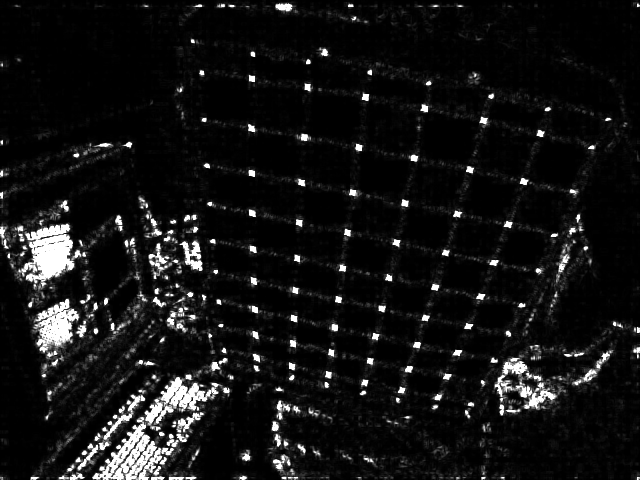

In [5]:
corner_strength = harris(img, radius=1)
show_image(corner_strength * 255)

Note that the corners of interest are clearly standing out, while most of the rest is suppressed. Of course, the filter is also highlighing other features that do not belong to the target.

However, let's first find where the corners are, whether on the target or not, by performing non-maxima suppression. This is is equivalent to finding the locations of the local maxima of the Harris response image. A simple algorithm to do that is to dilate the same response image by a small kernel, and then find the pixels where the dilated version agrees with the original. This works because, by definition, a morphological dilation replaces each pixel with the maximum within the kernel area, and therefore cannot change the values of the image's local maxima.

In [6]:
def local_maxima(img, radius=3, num=100):
    """
    Locate the most salient local maxima of an image, using a kernel of given size
    :param img : numpy array storing a single-channel image.
    :param radius : half-width of the applied morphological dilation kernel.
    :param num : maximum number of most salient local maxima to return.
    :returns list of at most num (x, y) tuples containing the image coordinates of the found maxima.
    """
    # Dilate and match image and dilated version, getting _all_ the local maxima
    sel=cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dil=cv2.dilate(img, sel)
    mx = np.where(img == dil, np.ones(img.shape, dtype=np.int32), np.zeros(img.shape, dtype=np.int32))
    h, w = mx.shape
    lm = []
    for y in range(h):
        for x in range(w):
            if mx[y, x] == 1:
                lm.append((x, y))
    # Sort the local maxima by descending image intensity.
    lm = sorted(lm, key=lambda p: img[p[1], p[0]], reverse=True)
    # Traverse the sorted list, suppress a window of the same radius about each maximum, and 
    # select the first "num" that have not been suppressed.
    lms=[]
    for x, y in lm:
        if mx[y, x] == 0:
            # It has already been suppressed, discard it.
            continue
        lms.append((x, y))
        if len(lms) == num:
            break
        # Suppress neighbors to avoid duplicating nearby maxima.
        xmin=max(0, x - radius)
        xmax=min(w, x + radius + 1)
        ymin=max(0, y - radius)
        ymax=min(h, y + radius + 1)
        mx[ymin:ymax, xmin:xmax] = 0
    return lms
    

Let's use it to find, say, the top 300 maxima, and let's define a routine to visualize them on top of the image.

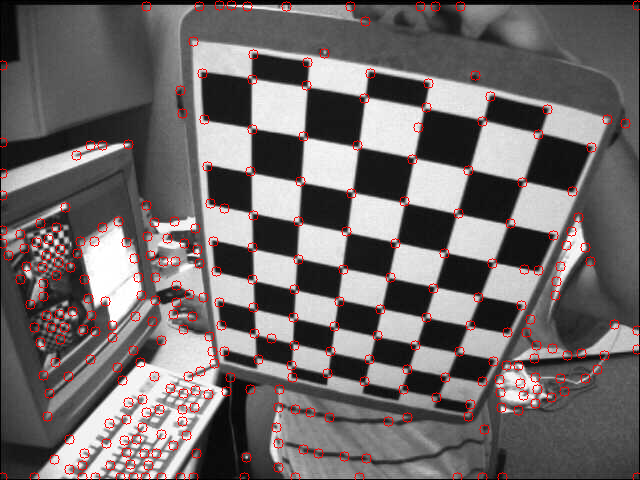

In [7]:
corners = local_maxima(corner_strength, radius=11, num=300)

def draw_corners(img, crs, show_id=False, valid=None):
    """
    Draw corners on top of the image
    :param img : numpy array storing a single-channel image.
    :crs : iterable of (x, y) tuples.
    """
    assert valid is None or len(valid) == len(crs)
    if img.ndim == 2:
        dimg = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    else:
        dimg = img.copy()
    for i, (x, y) in enumerate(crs):
        if valid is None or valid[i]:
            xy = (int(np.round(x)), int(np.round(y)))
            dimg = cv2.circle(dimg, xy, 5, (255, 0, 0), 1)
            if show_id:
                dimg = cv2.putText(dimg, str(i), (xy[0] + 5, xy[1] + 5),  
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0))
    return dimg

def show_corners(img, crs, show_id=False, valid=None, scale=1):
    """
    Draw and show corners on top of the image
    :param img : numpy array storing a single-channel image.
    :crs : iterable of (x, y) tuples.
    """
    show_image(draw_corners(img, crs, show_id, valid), scale)

show_corners(img, corners)

#### Subpixel refinement

So far, so good. However, the Harris-Stephens filter followed by non-maxima suppression has produced biased corner locations. This is clearly evident in the top portion of the target in the above image, where the painted corner locations appear a few pixels off the real ones. See image detail below.

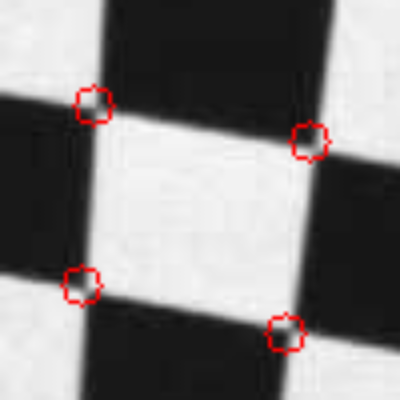

In [8]:
detail_img = img[110:210, 280:380]
show_corners(detail_img, np.array(corners) - [280, 110], scale=4)

The reason for the bias is multifaceted:
  * All filtering operations so far operated on integer pixel coordinates, but the target corners may project to a
    location in between pixels.
  * The non-maxima suppression algoritm select arbitrarily between neighboring salient maxima of the same or nearby values.

So we perform a sub-pixel refinement step that uses the checkerboard-like structure of the image about each corner to approximately locate its "saddle points". OpenCV has an implementaton of this iterative saddle point search.

In [9]:
# Search parameters
subpix_window = 7
zero_zone = 1
num_iterations = 10
subpix_threshold = 0.03

corners_subpix = cv2.cornerSubPix(
    img, np.float32(np.array(corners).reshape((-1, 1, 2))), 
    (subpix_window, subpix_window), (zero_zone, zero_zone), 
    (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
     num_iterations, subpix_threshold))

corners_subpix = np.reshape(corners_subpix, (-1, 2)).tolist()


Looking at the same detail image we can see that the subpixel-refined detections are much closer to where we expect them to be.

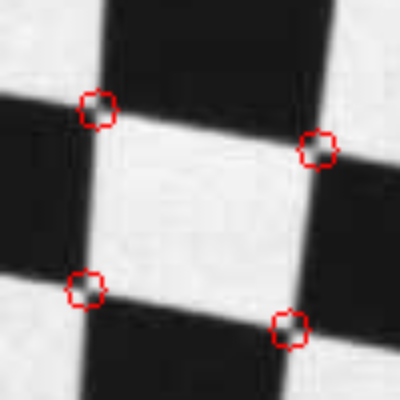

In [10]:
show_corners(detail_img, np.array(corners_subpix) - [280, 110], scale=4)


#### Adaptive Image Thresholding

We now need to convert the image from grayscale to black-white (binary), in such a way that the black and white portion faithfully represent the squares of the target checkerboard. It is best not to use a single black-white threshold for the entire image, because such thresholding would not be robust in the face of varying illumination across the image (in particular, across the target area). 

Rather, we need build an "image of thresholds", whose pixels are values that best separate, at each location, black from white. There are many possible ways to define "best", but for us the criterion is "best at separating the checkerboard's black and white squares _in the neighborhood of each detected corner_". 

Likewise, there are many ways to define the "neighborhood of a corner", but a simple one that has the advantage of both covering the image area and adapting to the varying distances of the corners from each other is the [_Voronoi diagram_](https://en.wikipedia.org/wiki/Voronoi_diagram) of the corners' distribution. OpenCV again has methods to build it.

In [11]:
def voronoi_facets(wid, hei, points):
    """
    Construct the Voronoi diagram of a set of points/
    :param wid, hei : height and width of the diagram
    :param points: iterable of (x, y) tuples
    :returns list of facets of the Voronoi diagram, each facet a list of vertices.
    """
    rect = (0, 0, wid, hei)
    sub2d = cv2.Subdiv2D(rect)
    sub2d.insert(points)
    facet_list, _ = sub2d.getVoronoiFacetList([])
    return facet_list

hei, wid = img.shape
facet_list = voronoi_facets(wid, hei, corners_subpix)

Let's "convert" the list of facets into the actual Voronoi diagram, which is an image. This way we can look at them and use the diagram for other purposes as well.

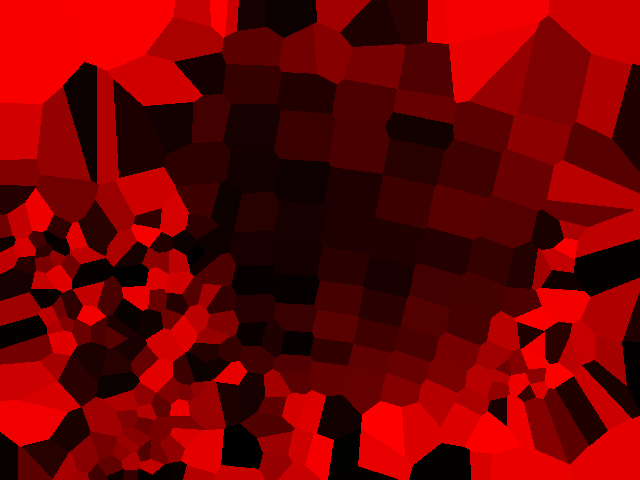

In [12]:
def voronoi_diagram(wid, hei, facet_list):
    """
    Draws an image of the Voronoi diagram, given its facets.
    :param wid, hei : height and width of the diagram.
    :facet_list: list of facets of the Voronoi diagram, each facet a list of vertices.
    :return numpy array of shape (hei, wid, 3), of type int32, whose RGB values encode indices in the facet_list.
    """
    assert len(facet_list) < (1 << 24), 'Can color only up to 2**24 -1 facets'
    int_facet_list = [np.round(np.array(f)).astype(np.int32) for f in facet_list]
    vdiagram = np.zeros((hei, wid, 3), dtype=np.uint8)
    for i, f in enumerate(int_facet_list):
        color = (i & 255, (i >> 8) & 255, (i >> 16) & 255)
        cv2.fillConvexPoly(vdiagram, np.array([f]), color)
    return vdiagram

vdiagram = voronoi_diagram(wid, hei, facet_list)
show_image(vdiagram)

Now let's compute the median grayscale value of the original image inside each facet of the diagram, then "color" each Voronoi facet with the median gray level.

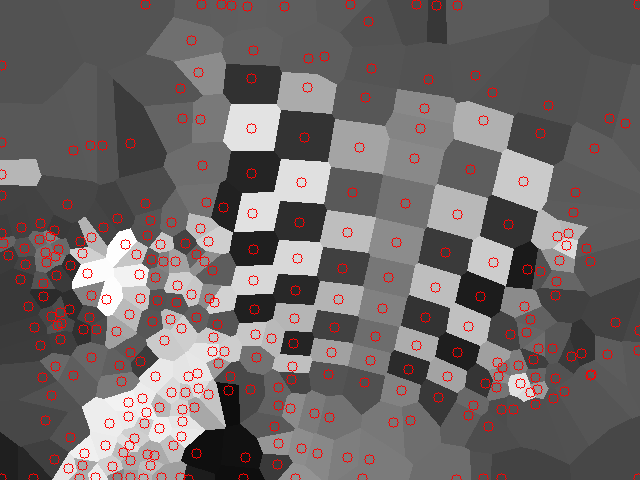

In [13]:
def compute_facet_medians(img, vdiagram, num_facets):
    """
    Computes the medians of the image histogram separately in each Voronoi facet.
    :param img : numpy array storing a single-channel image.
    :param vdiagram : numpy array of the same shape as width & height as img, as returned by method voronoi_diagram.
    :param num_facets : number of facets in the Voronoi diagram.
    :returns grayscale image of the same shape as img, with the Voronoi facets colored with the median gray level
             of img within them.
    """
    hei, wid = img.shape
    # Partition the image pixel values into sets, one for each facet
    vsets = [[] for _ in range(num_facets)]
    for y in range(hei):
        for x in range(wid):
            r, g, b = vdiagram[y, x, :]
            i = int(r) | (int(g) << 8) | (int(b) << 8)
            v = img[y, x]
            vsets[i].append(int(v))
    # Compute the list of medians of each set.
    meds=[np.uint8(np.median(v)) for v in vsets]
    # Build the image of medians
    medmap = np.zeros(img.shape, dtype=np.uint8)
    for y in range(hei):
        for x in range(wid):
            r, g, b = vdiagram[y, x, :]
            i = int(r) | (int(g) << 8) | (int(b) << 8)
            medmap[y, x] = meds[i]
    return medmap

num_corners = len(corners_subpix)
facet_medians = compute_facet_medians(img, vdiagram, num_corners)
with_corners_on_top = draw_corners(facet_medians, corners_subpix)
show_image(with_corners_on_top)

So far so good, these are almost the thresholds we want to use. However, the sharp transitions from one facets to the other are likely to produce artifacts in the thresholded image, so we blur it with a largish kernel. The result is the actual adaptive threshold image we'll use.

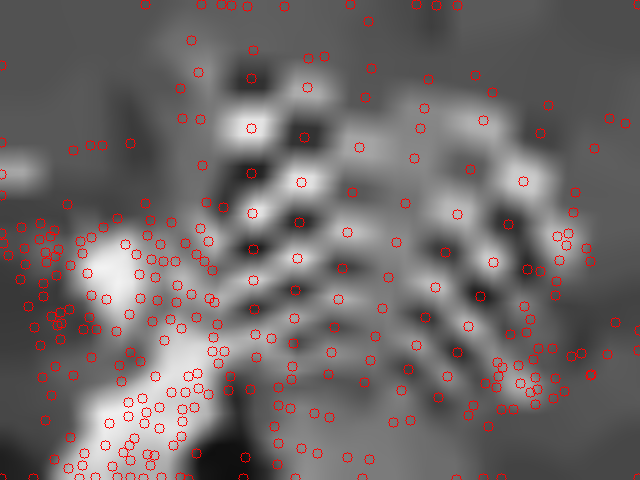

In [14]:
threshold_img = cv2.blur(facet_medians, ksize=(31, 31))
with_corners_on_top = draw_corners(threshold_img, corners_subpix)
show_image(with_corners_on_top)

Applying it to the original grayscale image produces the expected BW image. 

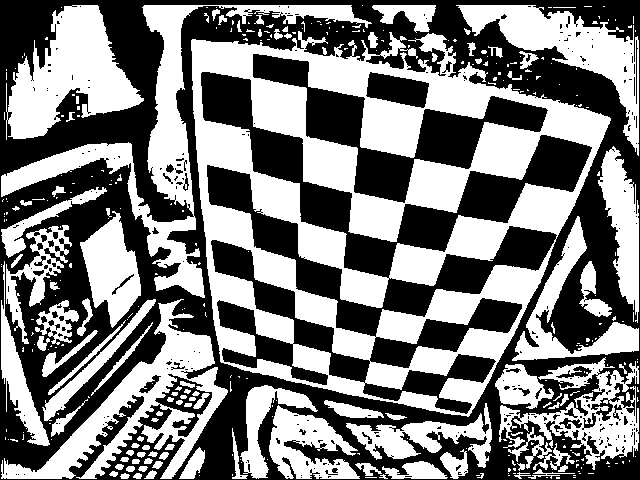

In [15]:
bw_img = cv2.compare(img, threshold_img, cv2.CMP_GT)
show_image(bw_img)

The small artifacts that are left on the target area could be eliminated with a little morphological filtering, but we need not bother for this study.

#### Black-White Region Segmentation and Corner Association

Let's proceed to separate the black and white regions and to associate them to the corners touching them. 

The images of the dark and light regions of the checkerboard pattern are separately detected on the binary (thresholded) image using a two-step procedure. The same steps are applied twice, first on the original binary image and then on its negative, respectively to detect the light regions and then the dark ones. The steps are: 

 1. _Feature neighborhood inversion_. Neighboring 1-valued regions of the binary image that correspond to different squares of the checkerboard often “leak” into each other, i.e. are joined by “bridges” a few pixel wide around the  corners. In order to ensure their separation, all the pixels in a small square region surrounding each corner are then set to 0. This is more efficient and robust than just doing a morphological erosion.
 2. _Connected components extraction_. All the connected components of pixels with value 1 are extracted from the  binary image using a standard floodfill algorithm. Each connected component is indicated by a unique integer, henceforth referred to as the "region index". All components are also represented in an auxiliary “region image” whose pixels have values equal to the index of the region they belong to. Finally, a “region color” table ```Cr``` is built, whose i-th entry indicates the color (1 or 0) of region.

In [16]:
def bw_area_detection(corners_subpix, bw_img, invert_block_radius=5):
    """
    Segments the black and white regions of a given BW image.
    :param corner_subpix : Nx2 array of feature points.
    :param bw_image : thresholded black-white image.
    :param invert_block_radius : radius of the region to be inverted around each feature point.
    :returns  pair of:
        region_image, an rgb image co-dimensional with bw_img, whose pixels encode the index of a segmented region.
        Cr: list such that Cr[i] is 1 iff region i is white, and 0 if it is black.
    """
    hei, wid = bw_img.shape
    # Build a list of quads around each corner
    quads = []
    for c in corners_subpix:
        x, y = tuple(np.int32(c))
        x0 = max(0, x - invert_block_radius)
        x1 = min(wid - 1, x + invert_block_radius)
        y0 = max(0, y - invert_block_radius)
        y1 = min(hei - 1, y + invert_block_radius)
        quad = [[x0, y0], [x1, y0], [x1, y1], [x0, y1]]
        quads.append(np.array(quad).reshape((4,1,2)))

    white_cc_img = bw_img.copy()
    for q in quads:
        cv2.fillConvexPoly(white_cc_img, q, 0)
    nw, white_cc = cv2.connectedComponents(
        white_cc_img, connectivity=4, ltype=cv2.CV_32S)

    ccbimg = 255 - bw_img
    for q in quads:
        cv2.fillConvexPoly(ccbimg, q, 0)
    nb, black_cc = cv2.connectedComponents(
        ccbimg, connectivity=4, ltype=cv2.CV_32S)
    
    region_image = black_cc
    region_colors = {}
    for i in range(hei):
        for j in range(wid):
            r = region_image[i, j]
            if region_image[i, j] == 0:
                w = white_cc[i, j]
                if w != 0:
                    r = nb + w - 1
                    region_image[i, j] = r
                    region_colors[r] = 1
            else:
                region_colors[r] = 0

    num_cc = nb + nw - 2
    assert len(region_colors) == num_cc
    return region_image, region_colors

region_image, Cr = bw_area_detection(corners_subpix, bw_img)

#### Corner-region, region-corner associations

The corners are associated with the connected components contiguous to them. The association is expressed through a
“corners-to-regions” table ```Fr```, such that ```Fr[i]``` corresponds the corner of index i, and its value is a list of indices of the regions that lie in a neighborhood of it. These are easily found through the ```region_image``` previously computed.

From the ```Fr``` table one can trivially obtain a "region-to-corners"  table ```Rf```, that expresses the inverse association. Each of its rows corresponds to an image region, and list all the corners lying at its boundary.

#### Removal of background and irregular regions

From now on the analysis will be restricted to the interior of the physical checkerboard pattern. Each interior corner
touches exactly four regions, and every interior region has exactly four corners. Consequently, all the rows of table
```Fr```  that do not contain exactly four region indexes are associated to corners inconsistent with an interior corner, and hence deleted from the table. Moreover, the indexes of these invalid corners are deleted from table ```Rf``` wherever they appear. Finally, all rows of table ```Rf``` left with less than four entries are deleted.

In [17]:
def corner_region_association(corners_subpix, region_image, Cr, radius=13):
    """
    Associates corners to black/white regions within a neighborhood of them of given radius.
    
    """
    num_cc = len(Cr)
    F = corners_subpix
    FI = np.int32(F)
    Fr={}
    rad=13
    for i, f in enumerate(FI):
        x, y = tuple(f)
        x0 = max(0, x - rad)
        x1 = min(wid - 1, x + rad)
        y0 = max(0, y - rad)
        y1 = min(hei - 1, y + rad)
        regs = set()
        # "Walk" around the feature along a square or radius rad.
        for xx in range(x0, x1):
            for yy in (y0, y1):
                r = region_image[yy, xx]
                if r != 0:
                    regs.add(r)
        for yy in range(y0, y1):
            for xx in (x0, x1):
                r = region_image[yy, xx]
                if r != 0:
                    regs.add(r)
        Fr[i] = regs
    
    # Invert index and remove background and irregular regions and features.
    Rf={i: set() for i in range(num_cc)}
    for i in list(Fr.keys()):
        regs = Fr[i]
        if len(regs) != 4:
            Fr.pop(i)
        else:
            num_whites = sum(1 for r in regs if Cr[r] == 1)
            if num_whites != 2:
                Fr.pop(i)
            else:
                for r in regs:
                    Rf[r].add(i)
                    
    for r in list(Rf.keys()):
        if len(Rf[r]) != 4:
            Rf.pop(r)
    for f, rs in list(Fr.items()):
        rs = [x for x in rs if x in Rf]
        Fr[f] = set(rs)
            
    return Fr, Rf


Let's apply the above function and plot the corners left after filtering. Notice how most of the corners outside the checkerboard are gone.

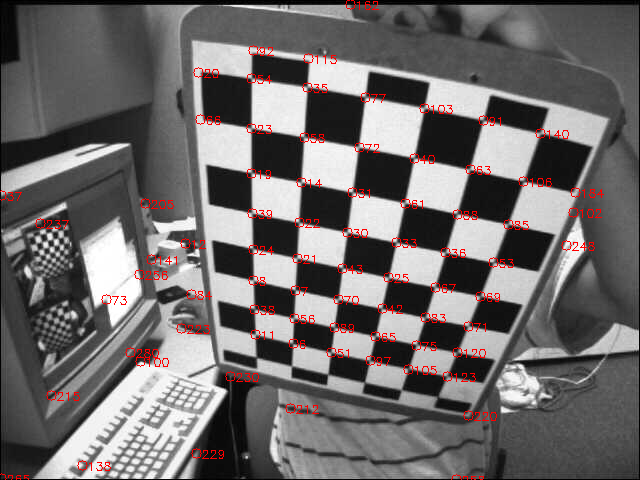

In [18]:
Fr, Rf = corner_region_association(corners_subpix, region_image, Cr)
# print('Fr=\n{}'.format(Fr))
# print('Rf=\n{}'.format(Rf))

valid_corners = [i in Fr for i, _ in enumerate(corners_subpix)]
show_corners(img, corners_subpix, show_id=True, valid=valid_corners)

Let's also display the regions found so far.

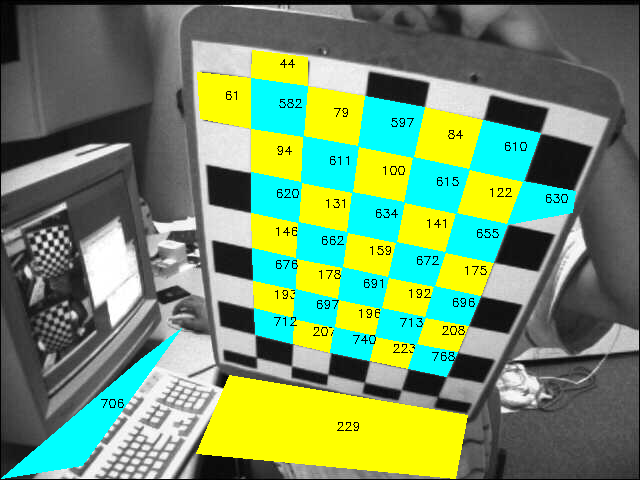

In [19]:
def draw_regions(img, corners_subpix, Fr, Rf, Cr, show_id=True):
    """
    Draws the regions whose indices are the keys of Rf, in
    yellow if the color in Cr is 1 (white), else cyan.
    """
    bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    yellow = (0, 255, 255)
    cyan = (255, 255, 0)
    for r, fs in Rf.items():
        crs = np.int32([corners_subpix[i] for i in fs])
        crs_reverse = np.array([crs[0,:], crs[2,:], crs[1,:], crs[3,:]])
        color = yellow if Cr[r] == 1 else cyan
        bgr = cv2.fillPoly(bgr, [crs.reshape((-1, 1, 2))], color=color)
        bgr = cv2.fillPoly(bgr, [crs_reverse.reshape((-1, 1, 2))], color=yellow if Cr[r] == 1 else cyan)
        if show_id:
            ctr = tuple(np.int32(np.mean(crs, 0)).tolist())
            bgr = cv2.putText(bgr, str(r), ctr, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0))
    return bgr

def show_regions(img, corners_subpix, Fr, Rf, Cr, show_id=True):
    bgr = draw_regions(img, corners_subpix, Fr, Rf, Cr, show_id=True)
    show_image(bgr)
        
show_regions(img, corners_subpix, Fr, Rf, Cr)

Notice how few invalid regions are left.
 
This is as far a simple image analysis can take us. To robustly match the checkerboard it is now necessary to analyze the topology of the detected corners and regions.

## Topological Analysis

This covers Section 3 of the paper.

As a result of the last removal step, the ```Fr``` and  ```Rf``` tables associate corners and regions that are not a–priori inconsistent with interior corners and squares of an image of the physical checkerboard pattern. I refer to them as _potentially_ defining a checkerboard. The ```Fr```, ```Rf``` and ```Cr``` tables are a computational representation of this checkerboard.

Let's now introduce the some definitions. Two distinct checkerboard corners are said to be _connected_ iff there exist a pair of distinct regions associated to both of them.  A _side_ is a synonim for a pair of connected corners. The two distinct regions associated to a side are said to be _adjoining_, the side being their _common boundary_. 

A region adjoining exactly four other distinct regions is said to be an _inner region_. 

A checkerboard is said to be _well formed_ (WF) if and only if it satisfies all the following conditions: 
  - Every pair of features is either not connected or connected by exactly one side. 
  - No regions with the same color are adjoining.
  - All pairs of regions are either not adjoining or adjoining on exactly one common boundary. 
  - Each region is adjoining one other region at least and four other regions at most.

Intuitively, a WF checkerboard is a mathematical representation of corners and regions that is consistent with the image of the physical checkerboard. 

#### Basic algorithms

The main topology analysis algorithm, to be introduced later, relies upon the following utility routines. These follow directly from the above definitions and the tabular representation of a checkerboard.

In [20]:
def common_regions_of_corners(i, j, Fr):
    return list(Fr[i].intersection(Fr[j]))

def are_connected_regions(regions, Cr):
    return len(regions) == 2 and Cr[regions[0]] != Cr[regions[1]]

def are_connected_corners(i, j, Fr, Cr):
    regions = common_regions_of_corners(i, j, Fr)
    return are_connected_regions(regions, Cr)

def regions_adjoining_side(i, j, Fr, Cr):
    regions = common_regions_of_corners(i, j, Fr)
    if not are_connected_regions(regions, Cr):
        return None
    else:
        return regions[0], regions[1]

Using the above routines one can now build a “region sides” table ```Rs``` , with one row
per region that lists all sides at the region’s boundary.

In [21]:
def region_sides(Fr, Rf, Cr):
    Rs = {}
    for r, fs in Rf.items():
        assert len(fs) == 4
        sides = []
        lfs = list(fs)
        for i, f in enumerate(lfs[:3]):
            for g in lfs[(i + 1):]:
                if are_connected_corners(f, g, Fr, Cr):
                    sides.append((f, g))
        assert len(sides) <= 4
        Rs[r] = sides
    return Rs

Rs = region_sides(Fr, Rf, Cr)
print('Example:')
print('Rs[662]={}'.format(Rs[662]))

Example:
Rs[662]=[(43, 21), (43, 30), (21, 22), (22, 30)]


Note carefully that ```Rs``` is a table of _pairs_ of corner indices,
since the elements of its rows elements are sides. 

The table is immediately used
to determine whether a region is inner or not:

Examples:
region 582 is inner? True
region 44 is inner? False
Verify in image below


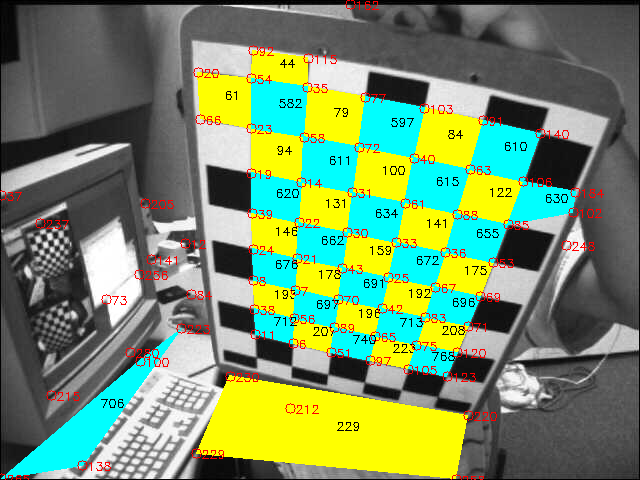

In [22]:
def is_inner_region(r, Rs):
    return r in Rs and len(Rs[r]) == 4

print('Examples:')
print('region 582 is inner? {}'.format(is_inner_region(582, Rs)))
print('region 44 is inner? {}'.format(is_inner_region(44, Rs)))
print('Verify in image below')
rgb = draw_regions(img, corners_subpix, Fr, Rf, Cr)
show_corners(rgb, corners_subpix, show_id=True, valid=valid_corners) 

The set of regions adjoining a given one is also readily
obtained via table Rs :

In [23]:
def regions_adjoining_region(r, Rs, Fr, Cr):
    adj = set()
    for s, t in Rs[r]:
        adj.update(regions_adjoining_side(s, t, Fr, Cr))
    return list(adj.difference([r]))

print('regions adjoining region 662 = {}'.format(regions_adjoining_region(662, Rs, Fr, Cr)))
print('regions adjoining region 175 = {}'.format(regions_adjoining_region(175, Rs, Fr, Cr)))

regions adjoining region 662 = [178, 131, 146, 159]
regions adjoining region 175 = [696, 655, 672]


And one can also determine, for a given inner region, which side is the opposite of a given one, and which two sides are adjoining:

In [24]:
def opposite_side(i, r, Rs):
    """
    Compute the opposite side to a given one in a region.
    :param i : index of one of the sides of region r.
    :param r : index of a region.
    :param Rs : the region-sides table
    :return the index j of the side opposite to the i-th one in Rs[r]
    """
    assert is_inner_region(r, Rs) and 0 <= i < 4
    sides = Rs[r]
    si = set(sides[i])
    for j, side in enumerate(sides):
        if j != i and not set(side).intersection(si):
            return j
        
def adjoining_sides(i, r, Rs):
    """
    Compute the pair of adjoining sides to a given one in a region.
    :param i : index of one of the sides of region r.
    :param r : index of a region.
    :param Rs : the region-sides table
    :return the indices (j, k) of the sides adjoining to the i-th one in Rs[r]    
    """
    j = opposite_side(i, r, Rs)
    return tuple(set(range(4)).difference([i, j]))

print('Examples:')
print('Corners region 662: {}'.format(Rf[662]))
print('Side 0 of region 662 is {}'.format(Rs[662][0]))
opp0 = opposite_side(0, 662, Rs)
print('its opposite side is {}: {}'.format(opp0, Rs[662][opp0]))
adj0 = adjoining_sides(0, 662, Rs)
print('its adjoining sides are {}: {}, {}'.format(adj0, Rs[662][adj0[0]], Rs[662][adj0[1]]))

Examples:
Corners region 662: {43, 21, 22, 30}
Side 0 of region 662 is (43, 21)
its opposite side is 3: (22, 30)
its adjoining sides are (1, 2): (43, 30), (21, 22)


These routines can be used to sort the sides of a region, and the corners of each side, according to the following tableau:

```
  0           1
   +---------+
   |    0    |
   |3       1|         Rs[r] = [(0, 1), (1, 2), (2, 3), (3, 0)]
   |    2    |
   +---------+
  3           2
```
That is, they can be sorted consistently with a clockwise ordering, up to an unknown rotation and/or reflection


In [25]:
def sort_sides_of_region(r, Rs):
    assert is_inner_region(r, Rs)
    i0 = 0
    i2 = opposite_side(i0, r, Rs)
    i1, i3 = adjoining_sides(i0, r, Rs)
    ss = Rs[r]
    s0, s1, s2, s3 = ss[i0], ss[i1], ss[i2], ss[i3]
    s01 = s0[1]
    if not s01 in s1:
        s1, s3 = s3, s1
        assert s01 in s1
    if s01 != s1[0]:
        s1 = (s1[1], s1[0])
    s11 = s1[1]
    assert s11 in s2
    if s11 != s2[0]:
        s2 = (s2[1], s2[0])
    s21 = s2[1]
    assert s21 in s3
    if s21 != s3[0]:
        s3 = (s3[1], s3[0])
    assert s3[1] == s0[0]
    Rs[r] = [s0, s1, s2, s3]
    
print('Example:')
print('Sides of region 662: {}'.format(Rs[662]))
sort_sides_of_region(662, Rs)
print('Sorted sides of region 662: {}'.format(Rs[662]))
print('Verify in picture above')

Example:
Sides of region 662: [(43, 21), (43, 30), (21, 22), (22, 30)]
Sorted sides of region 662: [(43, 21), (21, 22), (22, 30), (30, 43)]
Verify in picture above


Likewise, we can sort the sides and corners of a region to be consistent with the already-sorted corners of an adjacent one:

In [26]:
def sort_sides_consistently(r1, r0, i0, Rs):
    """
    Given region r1, adjacent to region r0 along the i0-th side of r0, 
    sorts the sides and corners of r1 in Rs to be consistent with r0.
    """
    assert is_inner_region(r0, Rs)
    assert is_inner_region(r1, Rs)
    assert 0 <= i0 < 4
    found = -1
    c0, c1 = Rs[r0][i0]
    found = False
    for i1, s1 in enumerate(Rs[r1]):
        if c0 in s1 and c1 in s1:
            found = True
            break
    assert found
    s1 = (c1, c0)
    if i1 != 0:
        s0 = Rs[r1][0]
        Rs[r1][0] = s1
        Rs[r1][i1] = s0
    else:
        Rs[r1][0] = s1
    sort_sides_of_region(r1, Rs)
    i_shft = [i % 4 for i in range(i0 + 2, i0 + 2 + 4)]
    ss1 = Rs[r1]
    ss1_shft = [None] * 4
    for i in range(4):
        j = (i0 + i + 2) % 4
        ss1_shft[j] = ss1[i]
    Rs[r1] = ss1_shft
    
print('Example:')
print('Sides of region 662: {}'.format(Rs[662]))
print('Sides of region 159: {}'.format(Rs[159]))
sort_sides_consistently(159, 662, 3, Rs)
print('Sorted sides of region 159: {}'.format(Rs[159]))
print('Sides of region 178: {}'.format(Rs[178]))
sort_sides_consistently(178, 662, 0, Rs)
print('Sorted sides of region 178: {}'.format(Rs[178]))


Example:
Sides of region 662: [(43, 21), (21, 22), (22, 30), (30, 43)]
Sides of region 159: [(25, 43), (25, 33), (43, 30), (30, 33)]
Sorted sides of region 159: [(25, 43), (43, 30), (30, 33), (33, 25)]
Sides of region 178: [(43, 21), (43, 70), (21, 7), (70, 7)]
Sorted sides of region 178: [(70, 7), (7, 21), (21, 43), (43, 70)]


#### Sorting the corners into a grid

This the main algorithm of the topological analysis section. Its goal is to place the checkerboard corners 
on a grid based on their locations with respect to each other. 

Here the term “location” does not refer to the
actual position of the features in the image, but rather to
their offsets within the checkerboard pattern, expressed in
units of one region. For example, two corners may be said
to be at offsets (1,3) from each other if they are separated by
one checkerboard region “horizontally” and 3 “vertically” (e.g. "one left and 3 down").

The algorithm is essentially a depht-first traversal of a graph
whose nodes are the inner regions of the checkerboard, and whose links are the 
common boundaries of adjoining regions. The checkerboard tables provide 
an implicit representation of the graph’s topology, which is made explicit
during the traversal itself. 

All topological inconsistencies that may lead to a non-WF condition are detected on the fly and
removed from the output. The output itself is a "grid" ```G```, defined as a two-dimensional array of feature indices, with the convention that a -1 value indicates a grid entry not assignedto any feature. The features not indexed by valid entries are eventually removed from .

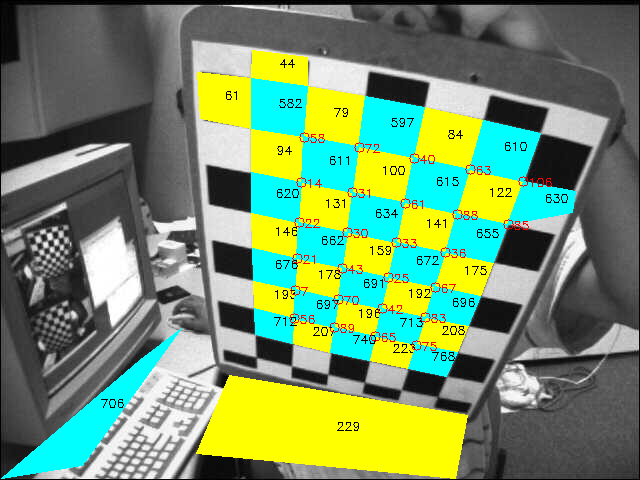

H =
[[ -1  -1  -1  -1  85 106]
 [ 75  83  67  36  88  63]
 [ 65  42  25  33  61  40]
 [ 89  70  43  30  31  72]
 [ 56   7  21  22  14  58]]
G =
{65: (2, 0), 67: (1, 2), 70: (3, 1), 7: (4, 1), 72: (3, 5), 75: (1, 0), 14: (4, 4), 83: (1, 1), 85: (0, 4), 22: (4, 3), 89: (3, 0), 88: (1, 4), 25: (2, 2), 30: (3, 3), 31: (3, 4), 33: (2, 3), 36: (1, 3), 40: (2, 5), 42: (2, 1), 43: (3, 2), 61: (2, 4), 56: (4, 0), 58: (4, 5), 21: (4, 2), 106: (0, 5), 63: (1, 5)}


In [27]:


def feature_offsets(corners_subpix, Fr, Rs, Cr):
    """
    Sort the detected corners into a 2D grid.
    :param corners_subpix List of (x, y) image position of detected checkerboard corners.
    :param Fr Corner-to-regions table as returned by function corner_region_association().
    :param Rs Region-to-sides tables as returned by function region_sides().
    :param Cr Region-colors table as returned by function bw_area_detection().
    :return Pair (H, G), where 
       H: an NxM numpy array of integers, such that its cell
          at position (i,j) contains the index of a corner in corners_subpix that has been 
          located therein. A value of -1 indicates that no corners has been located at (i, j)
       G: a dictionary mapping the indices of elements of corners_subpix into (i, j) positions
          into a 2D grid.
    """
    # Comments in the code will follow Section 3.1.1 of the paper.
    
    # Declare and fill with false values a boolean table Vs, having
    # the same size as the region sides table Rs . A region t is said to
    # be “entered from side s of the adjoining region r" if Vs[r][s] == True.
    Vs = {r: ([False] * len(sides)) for r, sides in Rs.items()}
    
    # Declare and fill with false values a boolean list Vr of length
    # equal to Rs. A region r is said to be “visited” when Vr[R] is true.
    Vr = {r: False for r in Rs.keys()}
    
    # Declare and fill with false values a boolean list I of size equal to Fr.
    # A feature of index k is said to be “inconsistent” if I[k] is true.
    I = {f: False for f in Fr.keys()}
    
    # Declare a dictionary F, keyed on the corner index, whose values
    # are the found row/column offset of that corner.
    G = {} 

    # Declare an empty stack S.
    S = []
    
    # Start from an inner region r adjoining only inner regions.
    found = False
    for r in Rs.keys():
        if is_inner_region(r, Rs):
            adj = regions_adjoining_region(r, Rs, Fr, Cr)
            if all([is_inner_region(a, Rs) for a in adj]):
                found = True
                break
                
    if not found:
        return None
    
    # Topologically sort the sides of region r.
    sort_sides_of_region(r, Rs)
    
    # Initialize traversal: mark region r visited
    Vr[r] = True
    
    # Initialize the region row and col. increments from r
    o_r = 0
    o_c = 0

    S.append((r, o_r, o_c))

    # Traversal: exterior loop over the stack.
    while S:
        r, o_r, o_c = S.pop()   
        # Inner loop
        while True:
            # Search for a side not already crossed from r 
            found = False
            for i in range(4):
                if not Vs[r][i]:
                    s = i
                    found = True
                    break
            if not found:
                break  # out of while True
            
            # Mark r entered from s, compute its corners’ offsets.
            Vs[r][s] = True
            
            if s == 0:
                r1 = o_r
                c1 = o_c
                r2 = r1
                c2 = c1 + 1
            elif s == 1:
                r1 = o_r
                c1 = o_c + 1
                r2 = r1 + 1
                c2 = c1
            elif s == 2:
                r1 = o_r + 1
                c1 = o_c + 1
                r2 = r1
                c2 = c1 - 1
            else:
                assert s == 3
                r1 = o_r + 1
                c1 = o_c
                r2 = r1 - 1
                c2 = c1

            # Enter offsets in grid if not inconsistent.
            f1, f2 = Rs[r][s]
            if I[f1] or I[f2]:
                print('inconsistent 1: {} {}'.format(I[f1], I[f2]))
                continue  # next "while True" iteration
            g1 = G.get(f1)
            g2 = G.get(f2)
            if g1 == (r1, c1) and g2 == (r2, c2):
                pass
            elif g1 is None and g2 is None:
                G[f1]=(r1,c1)
                G[f2]=(r2,c2)
            elif g1 == (r1, c1) and g2 is None:
                G[f2] = (r2, c2)
            elif g1 is None and g2 == (r2, c2):
                G[f1] = (r1, c1)
            else:
                I[f1] = I[f2] = True
                if f1 in G:
                    G.pop(f1)
                if f2 in G:
                    G.pop(f2)
                    
            if I[f1] or I[f2]:
                print('inconsistent 2: {} {}'.format(I[f1], I[f2]))
                continue  # next "while True" iteration
            
            # Step across side if adjoining region is inner too.
            a, b = regions_adjoining_side(f1, f2, Fr, Cr)
            if a == r:
                r_adj = b
            else:
                r_adj = a
            
            if not is_inner_region(r_adj, Rs):
                continue  # next "while True" iteration
 
            # If r_adj hasn’t been visited yet, topologically sort its sides
            # consistently with those of r.
            if not Vr[r_adj]:
                sort_sides_consistently(r_adj, r, s, Rs)
                Vr[r_adj] = True
            
            Vs[r_adj][(s + 2) % 4] = True
            # Update region offsets
            if s == 0:
                o_r -= 1
            elif s == 1:
                o_c += 1
            elif s == 2:
                o_r += 1
            else:
                assert s == 3
                o_c -= 1
                
            # New current region
            r = r_adj
            S.append((r, o_r, o_c))
            
        # end "while True"
    # end while Sr
    
    # Extract the valid inner rectangle of G
    G_vals = np.array(list(G.values()))
    MM, NN = np.max(G_vals, 0).tolist()
    mm, nn = np.min(G_vals, 0).tolist()
    m = MM - mm + 1
    n = NN - nn + 1
    H = -np.ones((m, n), dtype=np.int32)
    for f, (r, c) in G.items():
        o_r = r - mm
        o_c = c - nn
        H[o_r, o_c] = f
        G[f] = (o_r, o_c)
        
    # Rotate/Reflect H to conform to the image
    crs = np.array([list(c) for c in corners_subpix])
    dr = np.array([0., 0.])
    dc = np.array([0., 0.])
    for i in range(1, m):
        for j in range(1, n):
            hij = H[i, j]
            if hij >= 0:
                pij = crs[hij, :]
                if H[i - 1, j] >= 0:
                    qij = crs[H[i - 1, j], :]
                    dr += pij - qij
                if H[i, j - 1] >= 0:
                    qij = crs[H[i, j - 1], :]
                    dc += pij - qij
        
    return G, H


G, H = feature_offsets(corners_subpix, Fr, Rs, Cr)
indexed_corners = [i in G for i, _ in enumerate(corners_subpix)]
rgb = draw_regions(img, corners_subpix, Fr, Rf, Cr)
show_corners(rgb, corners_subpix, show_id=True, valid=indexed_corners) 
print('H =\n{}'.format(H))
print('G =\n{}'.format(G))

Notice how corners not belonging to the real checkerboard have been removed, and how H and G represent alternative views of an arrangement of the corners in a 2D grid.

However, the orientation of the grid as produced by the algorithm does not match the real one. More precisely:
 - The topology of H is correct in the sense that corners that are next to each other in the image are also next to each other in the retrieved grid.
 - However, if we regard H as an "image" with a top, bottom, etc, its geometry is a mirrored and rotated version of the actual one.
 
This geometric ambiguity, which cannot be resolved by a purely topological analysis, will be the subject of another notebook.